In [1]:
import census_mapper
from zipfile import ZipFile
import io
import shapefile
from shapely.geometry import shape
import osr
import geopandas as gpd
import matplotlib.pyplot as plt
import csv
import numpy as np
import folium
import random
import pysal
from tqdm import tqdm
#http://results.enr.clarityelections.com/GA/Fulton/71487/Web02/#/cid/40
#http://results.enr.clarityelections.com/GA/DeKalb/71471/Web02/#/cid/200
candidates = ['PeterAman', 'RohitAmmanamanchi', 'KeishaLanceBottoms', 'JohnEaves',\
              'VincentFort', 'KwanzaHall', 'CeasarMitchell', 'MaryNorwood',\
              'MichaelSterling', 'CathyWoolard', 'GlennWrightson']
# candidates = ['KeishaLanceBottoms', 'MaryNorwood', 'PeterAman',  \
#                'KwanzaHall', 'CeasarMitchell', 'CathyWoolard', 'VincentFort']
scheme = {}
for c in candidates:
    scheme[c] = 'grey'
scheme['KeishaLanceBottoms'] = 'blue'
scheme['MaryNorwood'] = '#00007f'
scheme['CathyWoolard'] = 'cyan'
scheme['VincentFort'] = 'red'
scheme['KwanzaHall'] = 'purple'
scheme['CeasarMitchell'] = '#00df00'
scheme['PeterAman'] = 'black'

In [2]:
results = {}
results2 = {}
with open("MayorResults2.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        p = row['Precinct']
        results[p] = {}
        results[p]["seen"] = 0
        for c in candidates:
            results[p][c] = int(row[c])

In [3]:
blocks = ZipFile('VTD2016-Shape.zip')
filenames = [y for y in sorted(blocks.namelist()) for ending in ['DBF', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
dbf, prj, shp, shx = [io.BytesIO(blocks.read(filename)) for filename in filenames]

r = shapefile.Reader(shp=shp, shx=shx, dbf=dbf)

attributes, geometry = [], []
field_names = [field[0] for field in r.fields[1:]]  
for row in r.shapeRecords():  
    geometry.append(shape(row.shape.__geo_interface__))  
    attributes.append(dict(zip(field_names, row.record)))  

proj4_string = osr.SpatialReference(prj.read().decode('UTF-8')).ExportToProj4()
print(proj4_string)

blockgdf = gpd.GeoDataFrame(data = attributes, geometry = geometry, crs = proj4_string)
print(blockgdf.head())

+proj=longlat +ellps=GRS80 +no_defs 
       AREA COUNTY COUNTY_NAM   CTYNAME CTYNUMBER CTYSOSID  DATA DISTRICT  \
0  1.864348    036   COLUMBIA  Columbia        36   073131   690   073131   
1  1.636596    036   COLUMBIA  Columbia        36   073064   714   073064   
2  5.598643    036   COLUMBIA  Columbia        36   073061   711   073061   
3  0.872412    036   COLUMBIA  Columbia        36   073063   713   073063   
4  3.783726    036   COLUMBIA  Columbia        36   073132   691   073132   

   FIPS1 FIPS2       ID  POPULATION PRECINCT_I            PRECINCT_N  \
0  13073   073  6094217        1013        131  JOURNEY COMM. CHURCH   
1  13073   073  6094266        3858        064  GRACE BAPTIST CHURCH   
2  13073   073  6094297        1920        061       GREENBRIER HIGH   
3  13073   073  6094341        1770        063  RIVERSIDE ELEMENTARY   
4  13073   073  6094377        3131        132      WESLEY METHODIST   

                                            geometry  
0  POLYGON (

In [4]:
for col in blockgdf.columns:
    if col not in ['PRECINCT_N', 'geometry', 'COUNTY_NAM']:
        del blockgdf[col]
print(blockgdf.head())

  COUNTY_NAM            PRECINCT_N  \
0   COLUMBIA  JOURNEY COMM. CHURCH   
1   COLUMBIA  GRACE BAPTIST CHURCH   
2   COLUMBIA       GREENBRIER HIGH   
3   COLUMBIA  RIVERSIDE ELEMENTARY   
4   COLUMBIA      WESLEY METHODIST   

                                            geometry  
0  POLYGON ((-82.14546199999999 33.57854, -82.145...  
1  POLYGON ((-82.16342400000001 33.574227, -82.16...  
2  POLYGON ((-82.16580999999999 33.564983, -82.16...  
3  POLYGON ((-82.139089 33.575924, -82.139141 33....  
4  POLYGON ((-82.14330200000001 33.573481, -82.14...  


In [5]:
atl = ZipFile('Atlanta_City_Limits.zip')
filenames = [y for y in sorted(atl.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
dbf, prj, shp, shx = [io.BytesIO(atl.read(filename)) for filename in filenames]

r = shapefile.Reader(shp=shp, shx=shx, dbf=dbf)

attributes, geometry = [], []
field_names = [field[0] for field in r.fields[1:]]  
for row in r.shapeRecords():  
    geometry.append(shape(row.shape.__geo_interface__))  
    attributes.append(dict(zip(field_names, row.record)))  

proj4_string = osr.SpatialReference(prj.read().decode('UTF-8')).ExportToProj4()
print(proj4_string)

atlgdf = gpd.GeoDataFrame(data = attributes, geometry = geometry, crs = proj4_string)
print(atlgdf.head())

+proj=longlat +ellps=WGS84 +no_defs 
     ACRES                                GLOBALID  ID    LABEL  OBJECTID  \
0  86643.1  {6999F328-8F07-4EE0-BF8C-4DB531A3898C}   0  Atlanta         1   

   OBJECTID_1    SHAPE_Area     SHAPE_Leng  SQ_MILES  \
0           1  5.087264e+08  195314.168371    135.38   

                                            geometry  
0  (POLYGON ((-84.42135081494511 33.6588738469827...  


In [6]:
blockgdf = blockgdf[blockgdf.geometry.is_valid == True]
fultongdf = blockgdf#[blockgdf.geometry.intersects(atlgdf.geometry[0])]
for can in candidates:
    fultongdf[can] = list(0 for i in range(len(fultongdf.index)))
fultongdf['valid'] = list(1 for i in range(len(fultongdf.index)))
#fultongdf.head()

Hole lies outside shell at or near point -85.053831000000002 33.557747999999997
Self-intersection at or near point -83.815736999999999 31.134574000000001
Self-intersection at or near point -84.298665 32.999670999999999
Self-intersection at or near point -84.442705000000004 31.787783000000001
Self-intersection at or near point -84.305204000000003 31.691058000000002
Self-intersection at or near point -84.363215999999994 32.397649000000001
Hole lies outside shell at or near point -82.318845999999994 31.190882999999999
Nested shells at or near point -80.845720999999998 32.013809999999999
Self-intersection at or near point -84.963710000000006 34.502453000000003
Hole lies outside shell at or near point -84.939076999999997 34.481822000000001
Hole lies outside shell at or near point -84.917072000000005 34.431766000000003
Self-intersection at or near point -84.856515000000002 34.166567000000001
Hole lies outside shell at or near point -85.131073000000001 34.213054999999997
Hole lies outside she

In [8]:
c = 0
tally = {}
for can in candidates:
    tally[can] = list(0 for i in range(len(fultongdf.index)))
for i, row in tqdm(fultongdf.iterrows()):
    pre = row['PRECINCT_N']
    if pre in results:
        results[pre]["seen"] = 1
        for can in candidates:
            tally[can][c] = results[pre][can]
#         if len(results[pre]) > 0:
#             for can in candidates:
#                 fultongdf.loc[i,can] = float(results[pre][can])
#             fultongdf.loc[i,'FortP'] = float(results[pre])
#             fultongdf.loc[i,'Fort'] = float(results2[pre])
#             fultongdf.loc[i,'FortA'] = float(results2[pre]) / row['AREA']
#             if row['POPULATION'] == 0:
#                 fultongdf.loc[i, 'FortPC'] = 0
#             else:
#                 fultongdf.loc[i,'FortPC'] = float(results2[pre]) / row['POPULATION']
        c += 1
    else:
        fultongdf.loc[i,'valid'] = 0

fultongdf = fultongdf[fultongdf['valid'] == 1]
        
for can in candidates:
    fultongdf[can] = tally[can]
print(c)
# 
missed = []
for p in results:
    if results[p]["seen"] == 0:
        print(p)
        missed.append(p)

169it [00:00, 7041.41it/s]


169
01G
01I


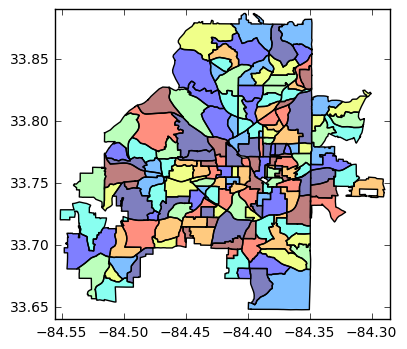

In [19]:
# for b in blockgdf[blockgdf["COUNTY_NAM"] == "DEKALB"]["PRECINCT_N"]:
#     print(b)

# for i, row in (blockgdf[blockgdf.geometry.intersects(atlgdf.geometry[0])]).iterrows():
#     if row["COUNTY_NAM"] == "DEKALB":
#         print(row["PRECINCT_N"])
plt.clf()
fultongdf.plot()
plt.xlim((-84.555,-84.285))
plt.ylim((33.64,33.89))
plt.show()

# plt.clf()
# census_mapper.gen_points_in_gdf_polys(geometry=fultongdf.geometry,\
#                                             values=fultongdf["VincentFort"],\
#                                             points_per_value=5).plot()
# plt.show()

In [22]:
pts = {}
for c in tqdm(candidates):
    print(c)
    pts[c] = census_mapper.gen_points_in_gdf_polys(geometry=fultongdf.geometry,\
                                            values=fultongdf[c],\
                                            points_per_value=3)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

PeterAman


  9%|███████▌                                                                           | 1/11 [00:01<00:15,  1.54s/it]

RohitAmmanamanchi
KeishaLanceBottoms


 27%|██████████████████████▋                                                            | 3/11 [00:05<00:13,  1.68s/it]

JohnEaves


 36%|██████████████████████████████▏                                                    | 4/11 [00:05<00:09,  1.32s/it]

VincentFort


 45%|█████████████████████████████████████▋                                             | 5/11 [00:06<00:08,  1.35s/it]

KwanzaHall


 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:07<00:06,  1.24s/it]

CeasarMitchell


 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:08<00:05,  1.26s/it]

MaryNorwood


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [00:11<00:04,  1.44s/it]

MichaelSterling
CathyWoolard


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:13<00:01,  1.34s/it]

GlennWrightson


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:13<00:00,  1.22s/it]


In [23]:

for c in tqdm(candidates):

    plt.clf()

    fig, ax = plt.subplots(figsize=(20,20))
    #fultongdf.geometry.plot(color='none',ax = ax, edgecolor="0.8")

    pts[c].plot(color=scheme[c], marker='o', markeredgecolor='none', markersize=4, ax=ax, alpha=1)
    #fultongdf.plot(ax = ax, column='FortP')


    plt.tight_layout()
    plt.axis("off")
    plt.xlim((-84.555,-84.285))
    plt.ylim((33.64,33.89))
    #plt.show()
    plt.savefig("img/"+c+".png", transparent=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:21<00:00,  7.43s/it]


In [24]:
fig, ax = plt.subplots(figsize=(20,20))
fultongdf.geometry.plot(color='none',ax = ax, edgecolor="0.8")



plt.tight_layout()
plt.axis("off")
plt.xlim((-84.555,-84.285))
plt.ylim((33.64,33.89))

plt.savefig("img/Map.png", transparent=True)

In [ ]:
plt.clf()
dek = blockgdf[blockgdf['COUNTY_NAM']=="DEKALB"]
dek = dek[dek.geometry.intersects(atlgdf.geometry[0])]
# dek['coords'] = dek['geometry'].apply(lambda x: x.representative_point().coords[:])
# dek['coords'] = list([coords[0] for coords in c['coords']])
dek.plot(figsize=(10, 10))
for idx, row in dek.iterrows():
    #print(dir(row.geometry.))
    #print(dir(row['geometry'].centroid))
    c = row['geometry'].centroid
    plt.annotate(s=row['PRECINCT_N'], xy=(c.x, c.y))
plt.show()
dek